# Demo

The `pymultifracs` package allows us to perform fractal and multifractal analysis of signals

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
sns.set(style="whitegrid")
sns.set_context('notebook')

## Loading a real signal

First load a signal from a real, preprocessed MEG recording

In [5]:
with open('signal.npy', 'rb') as f:
    X = np.load(f)

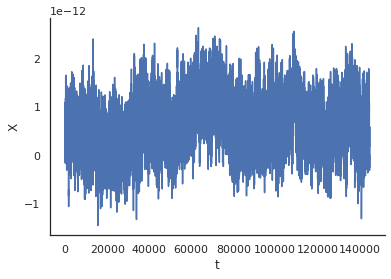

In [6]:
plt.plot(X)
sns.despine()
plt.ylabel('X')
plt.xlabel('t')
plt.show()

## PSD

Display the Power Spectral Density of the signal, computed using wavelet and Fourier based estimators

In [7]:
import pymultifracs.psd as psd

fs = 2000

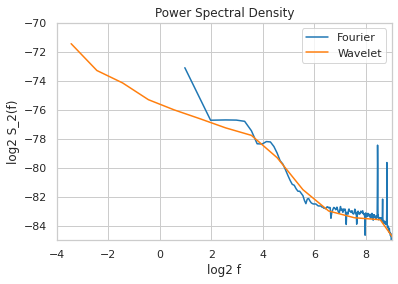

In [9]:
psd.plot_psd(X, fs, n_fft=1024)
plt.xlim((-4, 9))
plt.ylim((-85, -70))
plt.show()

Here we can clearly see the signal is scale-free in the infra-slow range ($\log_2 f < 3$)

We will therefore proceed with the analysis in this range of frequencies: $f < 2^2$

We need then to determine the scale range to use for the analysis

### scale-frequency relationship

There is a direct inverse relation between scale and frequency, which can be used with the `scale2freq` and `freq2scale` functions.
The relationship is dependant on the sampling frequency, here 2000Hz

In [10]:
from pymultifracs.utils import scale2freq, freq2scale
fs = 2000

We're looking for a scale that corresponds to a frequency below 4Hz

In [11]:
freq2scale(4, fs)

8.550746785383243

Here since the ouptut is not an int, we need to round it to the next higher integer, giving us a scale of 9 which will be our lower bound for the scale range.

We can check to what frequency a scale of 9 corresponds

In [12]:
scale2freq(9, fs)

2.9296875

In [13]:
j1 = 9

The upper bound for our scale range can be determined using the rule of thumb: $j_2 = \log_2 N - 3$.
The aim is to avoid relying on the highest scales, since for these scales there are not many wavelet coefficients computed -- meaning that the variance of the estimates at these scales will be high.

In [20]:
j2 = np.floor(np.log2(len(X)) - 3)

Note: When analysing multiple signals at once, it should be done using the same frequency range for all. Pay special attention when working with signals that have different sampling frequencies, as either they need to be resampled to the same frequency, or the scale ranges will have to be different for each frequency.

Note: When performing analysis on signals of different length, the shortest one should be used for determining the highest usable scale.

## Wavelet Analysis

We first perform the wavelet filtering in order to have an estimate of `hmin`, which indicates us what value to set for `gamint`

In [15]:
from pymultifracs.estimation import estimate_hmin
from pymultifracs.wavelet import wavelet_analysis

In [23]:
WT = wavelet_analysis(X, j1=j1, j2=j2, gamint=0.0)
hmin, _ = estimate_hmin(WT.wt_coefs, 10, WT.j2_eff, weighted=True)

In [27]:
hmin

array([-0.34879718])

Here since `hmin` is negative, this means that in order for the estimation of the multifractal parameters to be correct, we need to set a higer value of `gamint`.

`gamint` is the fractional integration parameter, and increases in this parameters will raise `hmin` by the same amount.
It is recommended to use multiples of 0.5. In this case, setting `gamint` to 0.5 is enough.

Note that in the case of MEG signals, the value will most often be higher than 1.

In case the value of `j2` chosen was too high, an automatic correction will take place and the `WT.j2_eff` variable contains the effective j2 value used in the analysis.

In [29]:
gamint = 0.5

**Using p-leaders**

## Multifractal analysis

In [31]:
import pymultifracs.mfa as mfa
from pymultifracs.utils import build_q_log

In [50]:
dwt, lwt = mfa.mf_analysis_full(X,
    j1=j1, j2=WT.j2_eff,
    q = build_q_log(1, 10, 20),
    n_cumul=2,
    p_exp=2,
    gamint=0.5,
    weighted=False
)

We can check that our correction was good by checking the `hmin` value of the signal that was analysed. As long as it is strictly positive it fine, otherwise `gamint` would need to be increased

In [51]:
dwt.hmin

array([0.22593656])

The `dwt` variable contains the output of the multifractal analysis of the wavelet coefficients, and `lwt` of the wavelet leaders (or p-leaders if `p_exp` is an int, as is the case here)

#### structure functions

We use the wavelet coef-based results to get the $H$ estimate

In [77]:
dwt.structure.H

array([-0.08008548])

We can also plot the structure functions in order to check the scaling properties of the signal for multiple moments $q$.

We're making sure that overall the behavior of the structure functions is scale-free in our scale range

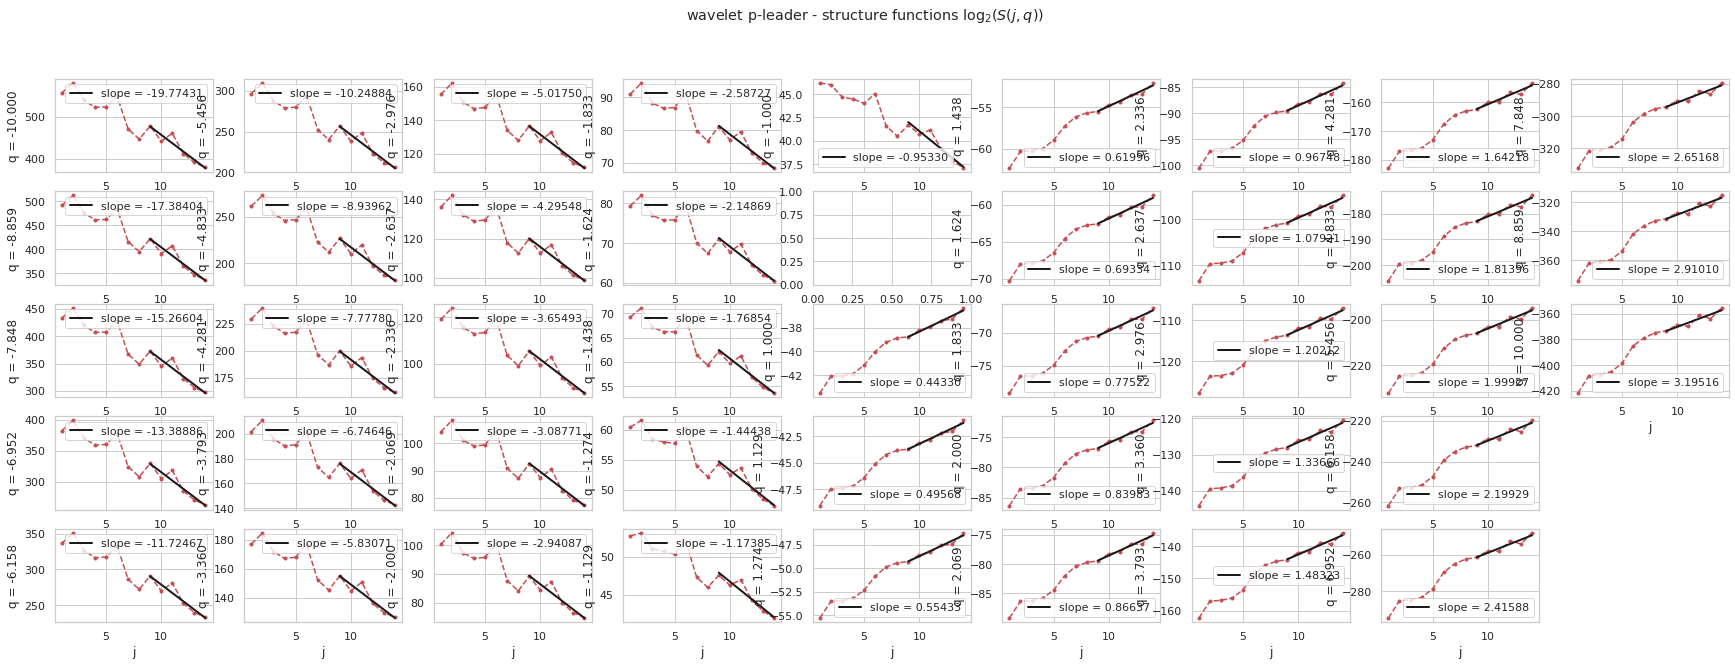

In [64]:
dwt.structure.plot(nrow=5)

#### cumulants

Plotting the cumulant functions is done as below:

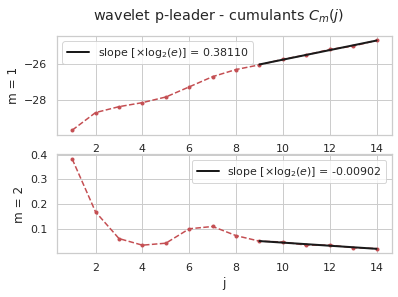

In [62]:
lwt.cumulants.plot()

This plot is used to make sure the estimation of the slopes (called log-cumulants $c_1$ and $c_2$) is done correctly.

We can also directly access the values of the slopes:

In [68]:
lwt.cumulants.c1, lwt.cumulants.c2

(array([[0.38109738]]), array([[-0.00901538]]))

The $M = -c2$ estimate is obtained as follows:

In [65]:
lwt.cumulants.M

array([[0.00901538]])

#### mutlifractal spectrum

Drawing the multifractal spectrum allows us to visualize the $h$ distribution.

The mode of the spectrum is $c_1$, and the spread is $c_2$

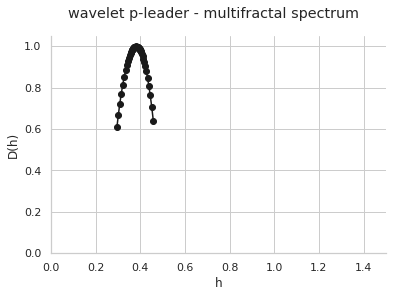

In [74]:
lwt.spectrum.plot()
sns.despine()